## Trending Youtube Videos Statistics
#### BA 820 Team B2

#### Team members: Phyllis Cao, Zihan Cui, Aash Gohil, Chunxiaqiu(Tommy) Yang, Zixing Li

## A. Business Problem
YouTube is an online video-sharing platform owned by Google, used by both multimillion-dollar
corporations as well as individual content creators. Its content is accessible from various platforms such
as computers, phones, gaming consoles as well as smart TVs. It is one of the stickiest digital products
with a stickiness factor of 0.13 with 315.12 million daily active users, and 2.3 billion monthly active
users, and generated $19.7 billion in revenue in 2020.

The motivation for this project stemmed from analyzing digital image products like apple photos, which
create annual album collages for its users based on their photo library and ML algorithms. In the future,
YouTube can also create personalized playlists based on each person's video history, and this project can
serve as a pilot for individual playlist customization.

## B. Dataset 
https://www.kaggle.com/datasnaek/youtube-new?select=USvideos.csv


The dataset we are going to use is Trending YouTube Video Statistics, which was downloaded from
Kaggle (The data set was originally extracted from the YouTube library). This dataset includes several
months of data on daily trending YouTube videos. The dataset contains trending videos from the USA,
Great Britain, Germany, Canada, France, and Japan. We will be focusing on US video data.
The dataset consists of 40949 records of YouTube videos (6351 unique values), 16 features with a
mixture of data types. For example, string (text), categorical, and numeric variables.

## C. Install & Import required packages

In [ ]:
#installs
! pip install scikit-plot
! pip install newspaper3k
! pip install -U spacy
! pip install -U textacy
! pip install wordcloud
! pip install emoji
! pip install nltk
! pip install scikit-plot
! pip install spacytextblob
! pip install umap-learn
! pip install afinn
! pip install pysrt
! pip install textdescriptives
! pip install tokenwiser


In [ ]:
# imports
from sklearn.datasets import load_digits, fetch_openml
from sklearn.model_selection import train_test_split
import os
import numpy as np
from PIL import Image
import uuid
import pandas as pd
import cv2   
import random
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
# sklearn does have some functionality too, but mostly a wrapper to scipy
from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn import metrics 
from sklearn.datasets import make_blobs
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt

# what we need for today
from sklearn.decomposition import PCA
from sklearn import metrics 

import scikitplot as skplt

# color maps
from matplotlib import cm

# some "fun" packages
from wordcloud import WordCloud
import emoji
import re

# text imports

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer  
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import json

# text imports
from spacy import cli
import textdescriptives as td
import tokenwiser
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import gensim
from afinn import Afinn
from newspaper import Article
from umap import UMAP
import warnings
warnings.filterwarnings("ignore")

# for distance and h-clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

#for k-means
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, silhouette_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## D. Data Cleaning 

In [ ]:
## Importing trending data from local
youtube = pd.read_csv("/content/USvideos.csv")

In [ ]:
youtube.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [ ]:
youtube.shape

(40949, 16)

In [ ]:
youtube.isna().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64

In [ ]:
## Importing json file category id, this file cointains mapping of category id to the category name, adding the mapped category name to original file

with open('/content/US_category_id.json') as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
youtube['category_name'] = youtube['category_id'].map(cat_dict)

In [ ]:
youtube.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",Entertainment
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,Entertainment
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,Entertainment


In [ ]:
## The trending_date is in yy.dd.mm format
## Creating a new df with a feature number of days trending based on trending_date and video_id
days_trending_df = youtube.groupby('video_id')['trending_date'].count().to_frame('num_days_trending').reset_index()

In [ ]:
days_trending_df.head()

,video_id,num_days_trending
0,-0CMnp02rNY,6
1,-0NYY8cqdiQ,1
2,-1Hm41N0dUs,3
3,-1yT-K3c6YI,4
4,-2RVw2_QyxQ,3


In [ ]:
## Converting trending date to date time format
youtube['trending_date'] = pd.to_datetime(youtube['trending_date'],format='%y.%d.%m')

In [ ]:
## Since a video can be trending over multiple days, we want the data from the last day it was trending.
## We will use the rank function to find the last entry of trending data for a video_id, the row_num value for this will be 1

youtube['row_num'] = youtube.groupby(['video_id'])['trending_date'].rank(method='first', ascending = False)

In [ ]:
## Verifying ranking, the entry with the latest date is ranked as 1

youtube[youtube['video_id'] == '-0CMnp02rNY']

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,row_num
39169,-0CMnp02rNY,2018-06-06,Mindy Kaling's Daughter Had the Perfect Reacti...,TheEllenShow,24,2018-06-04T13:00:00.000Z,"ellen|""ellen degeneres""|""the ellen show""|""elle...",475965,6531,172,271,https://i.ytimg.com/vi/-0CMnp02rNY/default.jpg,False,False,False,Ocean's 8 star Mindy Kaling dished on bringing...,Entertainment,6.0
39375,-0CMnp02rNY,2018-06-07,Mindy Kaling's Daughter Had the Perfect Reacti...,TheEllenShow,24,2018-06-04T13:00:00.000Z,"ellen|""ellen degeneres""|""the ellen show""|""elle...",605506,7848,232,354,https://i.ytimg.com/vi/-0CMnp02rNY/default.jpg,False,False,False,Ocean's 8 star Mindy Kaling dished on bringing...,Entertainment,5.0
39584,-0CMnp02rNY,2018-06-08,Mindy Kaling's Daughter Had the Perfect Reacti...,TheEllenShow,24,2018-06-04T13:00:00.000Z,"ellen|""ellen degeneres""|""the ellen show""|""elle...",705986,8930,277,371,https://i.ytimg.com/vi/-0CMnp02rNY/default.jpg,False,False,False,Ocean's 8 star Mindy Kaling dished on bringing...,Entertainment,4.0
39795,-0CMnp02rNY,2018-06-09,Mindy Kaling's Daughter Had the Perfect Reacti...,TheEllenShow,24,2018-06-04T13:00:00.000Z,"ellen|""ellen degeneres""|""the ellen show""|""elle...",754273,9395,303,383,https://i.ytimg.com/vi/-0CMnp02rNY/default.jpg,False,False,False,Ocean's 8 star Mindy Kaling dished on bringing...,Entertainment,3.0
40007,-0CMnp02rNY,2018-06-10,Mindy Kaling's Daughter Had the Perfect Reacti...,TheEllenShow,24,2018-06-04T13:00:00.000Z,"ellen|""ellen degeneres""|""the ellen show""|""elle...",792613,9720,330,413,https://i.ytimg.com/vi/-0CMnp02rNY/default.jpg,False,False,False,Ocean's 8 star Mindy Kaling dished on bringing...,Entertainment,2.0
40208,-0CMnp02rNY,2018-06-11,Mindy Kaling's Daughter Had the Perfect Reacti...,TheEllenShow,24,2018-06-04T13:00:00.000Z,"ellen|""ellen degeneres""|""the ellen show""|""elle...",800359,9773,332,423,https://i.ytimg.com/vi/-0CMnp02rNY/default.jpg,False,False,False,Ocean's 8 star Mindy Kaling dished on bringing...,Entertainment,1.0


In [ ]:
##Filtering values for row num equal to 1

youtube_clean = youtube[youtube['row_num'] == 1].reset_index(drop=True)

In [ ]:
youtube_clean.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,row_num
0,9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,17,2017-11-13T02:05:26.000Z,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,False,False,False,New England Patriots returner Dion Lewis blast...,Sports,1.0
1,Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,1,2017-11-12T18:00:03.000Z,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,False,False,False,With Justice League approaching fast we rewatc...,Film & Animation,1.0
2,goP4Z5wyOlM,2017-11-14,Iraq-Iran earthquake: Deadly tremor hits borde...,BBC News,25,2017-11-12T21:16:40.000Z,"bbc|""bbc news""|""news""|""iran""|""iran news""|""iraq...",34785,308,26,413,https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg,False,False,False,A strong 7.2-magnitude earthquake has rattled ...,News & Politics,1.0
3,8NHA23f7LvU,2017-11-14,Jason Momoa Wows Hugh Grant With Some Dothraki...,The Graham Norton Show,24,2017-11-10T19:06:23.000Z,"Graham Norton|""Graham Norton Show Official""|""E...",1496225,16116,236,605,https://i.ytimg.com/vi/8NHA23f7LvU/default.jpg,False,False,False,I think Sarah Millican was very excited for th...,Entertainment,1.0
4,IE-xepGLVt8,2017-11-14,Mayo Clinic's first face transplant patient me...,Mayo Clinic,28,2017-11-10T12:04:17.000Z,"Mayo Clinic|""Health Care (Issue)""|""Healthcare ...",237307,1896,74,260,https://i.ytimg.com/vi/IE-xepGLVt8/default.jpg,False,False,False,One and a half years after the surgery that tr...,Science & Technology,1.0


In [ ]:
youtube_clean.drop(['row_num'], axis=1, inplace=True)

In [ ]:
print(youtube_clean.shape)
print(days_trending_df.shape)

(6351, 17)
(6351, 2)


In [ ]:
## Joining days trending to clean youtube data, since only common colum is video_id pandas will merge on that
youtube_final = pd.merge(youtube_clean, days_trending_df)

In [ ]:
## Sanity check on merge
youtube_final[youtube_final['video_id'] == '-0CMnp02rNY']

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,num_days_trending
6106,-0CMnp02rNY,2018-06-11,Mindy Kaling's Daughter Had the Perfect Reacti...,TheEllenShow,24,2018-06-04T13:00:00.000Z,"ellen|""ellen degeneres""|""the ellen show""|""elle...",800359,9773,332,423,https://i.ytimg.com/vi/-0CMnp02rNY/default.jpg,False,False,False,Ocean's 8 star Mindy Kaling dished on bringing...,Entertainment,6


In [ ]:
##converting True False values to 1 and 0
youtube_final.replace({False: 0, True: 1}, inplace=True)

In [ ]:
youtube_final.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,num_days_trending
0,9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,17,2017-11-13T02:05:26.000Z,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,0,0,0,New England Patriots returner Dion Lewis blast...,Sports,1
1,Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,1,2017-11-12T18:00:03.000Z,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,0,0,0,With Justice League approaching fast we rewatc...,Film & Animation,1
2,goP4Z5wyOlM,2017-11-14,Iraq-Iran earthquake: Deadly tremor hits borde...,BBC News,25,2017-11-12T21:16:40.000Z,"bbc|""bbc news""|""news""|""iran""|""iran news""|""iraq...",34785,308,26,413,https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg,0,0,0,A strong 7.2-magnitude earthquake has rattled ...,News & Politics,1
3,8NHA23f7LvU,2017-11-14,Jason Momoa Wows Hugh Grant With Some Dothraki...,The Graham Norton Show,24,2017-11-10T19:06:23.000Z,"Graham Norton|""Graham Norton Show Official""|""E...",1496225,16116,236,605,https://i.ytimg.com/vi/8NHA23f7LvU/default.jpg,0,0,0,I think Sarah Millican was very excited for th...,Entertainment,1
4,IE-xepGLVt8,2017-11-14,Mayo Clinic's first face transplant patient me...,Mayo Clinic,28,2017-11-10T12:04:17.000Z,"Mayo Clinic|""Health Care (Issue)""|""Healthcare ...",237307,1896,74,260,https://i.ytimg.com/vi/IE-xepGLVt8/default.jpg,0,0,0,One and a half years after the surgery that tr...,Science & Technology,1


In [ ]:
youtube_final['tags'] = youtube_final['tags'].replace(to_replace='["|"]', regex=True, value=' ')

In [ ]:
youtube_final.description.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=[" "," "], regex=True, inplace=True)

In [ ]:
youtube_final.description[5]

'James congratulates Jason Momoa on recently marrying Lisa Bonnet, and learns the pair started out enjoying some Guinness and grits and never looked back.  More Late Late Show: Subscribe: http://bit.ly/CordenYouTube Watch Full Episodes: http://bit.ly/1ENyPw4 Facebook: http://on.fb.me/19PIHLC Twitter: http://bit.ly/1Iv0q6k Instagram: http://bit.ly/latelategram  Watch The Late Late Show with James Corden weeknights at 12:35 AM ET/11:35 PM CT. Only on CBS.  Get new episodes of shows you love across devices the next day, stream live TV, and watch full seasons of CBS fan favorites anytime, anywhere with CBS All Access. Try it free! http://bit.ly/1OQA29B  --- Each week night, THE LATE LATE SHOW with JAMES CORDEN throws the ultimate late night after party with a mix of celebrity guests, edgy musical acts, games and sketches. Corden differentiates his show by offering viewers a peek behind-the-scenes into the green room, bringing all of his guests out at once and lending his musical and acting

In [ ]:
youtube_final.description.replace(r'http\S+', '', regex=True, inplace=True)
youtube_final.description[5]

'James congratulates Jason Momoa on recently marrying Lisa Bonnet, and learns the pair started out enjoying some Guinness and grits and never looked back.  More Late Late Show: Subscribe:  Watch Full Episodes:  Facebook:  Twitter:  Instagram:   Watch The Late Late Show with James Corden weeknights at 12:35 AM ET/11:35 PM CT. Only on CBS.  Get new episodes of shows you love across devices the next day, stream live TV, and watch full seasons of CBS fan favorites anytime, anywhere with CBS All Access. Try it free!   --- Each week night, THE LATE LATE SHOW with JAMES CORDEN throws the ultimate late night after party with a mix of celebrity guests, edgy musical acts, games and sketches. Corden differentiates his show by offering viewers a peek behind-the-scenes into the green room, bringing all of his guests out at once and lending his musical and acting talents to various sketches. Additionally, bandleader Reggie Watts and the house band provide original, improvised music throughout the sh

In [ ]:
youtube_final.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,num_days_trending
0,9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,17,2017-11-13T02:05:26.000Z,NFL Football offense defense afc nfc ...,81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,0,0,0,New England Patriots returner Dion Lewis blast...,Sports,1
1,Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,1,2017-11-12T18:00:03.000Z,screenjunkies screen junkies sj news hone...,288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,0,0,0,With Justice League approaching fast we rewatc...,Film & Animation,1
2,goP4Z5wyOlM,2017-11-14,Iraq-Iran earthquake: Deadly tremor hits borde...,BBC News,25,2017-11-12T21:16:40.000Z,bbc bbc news news iran iran news iraq...,34785,308,26,413,https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg,0,0,0,A strong 7.2-magnitude earthquake has rattled ...,News & Politics,1
3,8NHA23f7LvU,2017-11-14,Jason Momoa Wows Hugh Grant With Some Dothraki...,The Graham Norton Show,24,2017-11-10T19:06:23.000Z,Graham Norton Graham Norton Show Official E...,1496225,16116,236,605,https://i.ytimg.com/vi/8NHA23f7LvU/default.jpg,0,0,0,I think Sarah Millican was very excited for th...,Entertainment,1
4,IE-xepGLVt8,2017-11-14,Mayo Clinic's first face transplant patient me...,Mayo Clinic,28,2017-11-10T12:04:17.000Z,Mayo Clinic Health Care (Issue) Healthcare ...,237307,1896,74,260,https://i.ytimg.com/vi/IE-xepGLVt8/default.jpg,0,0,0,One and a half years after the surgery that tr...,Science & Technology,1


In [ ]:
## Writing file to csv
youtube_final.to_csv('youtube_final.csv',index=False)

In [ ]:
youtube_final.shape

(6351, 18)

# E. EDA and Preliminary analysis

In [ ]:
df = pd.read_csv('https://github.com/aashgohil/BA820/raw/main/youtube_final.csv')

In [ ]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,num_days_trending
0,9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,17,2017-11-13T02:05:26.000Z,NFL Football offense defense afc nfc ...,81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,0,0,0,New England Patriots returner Dion Lewis blast...,Sports,1
1,Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,1,2017-11-12T18:00:03.000Z,screenjunkies screen junkies sj news hone...,288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,0,0,0,With Justice League approaching fast we rewatc...,Film & Animation,1
2,goP4Z5wyOlM,2017-11-14,Iraq-Iran earthquake: Deadly tremor hits borde...,BBC News,25,2017-11-12T21:16:40.000Z,bbc bbc news news iran iran news iraq...,34785,308,26,413,https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg,0,0,0,A strong 7.2-magnitude earthquake has rattled ...,News & Politics,1
3,8NHA23f7LvU,2017-11-14,Jason Momoa Wows Hugh Grant With Some Dothraki...,The Graham Norton Show,24,2017-11-10T19:06:23.000Z,Graham Norton Graham Norton Show Official E...,1496225,16116,236,605,https://i.ytimg.com/vi/8NHA23f7LvU/default.jpg,0,0,0,I think Sarah Millican was very excited for th...,Entertainment,1
4,IE-xepGLVt8,2017-11-14,Mayo Clinic's first face transplant patient me...,Mayo Clinic,28,2017-11-10T12:04:17.000Z,Mayo Clinic Health Care (Issue) Healthcare ...,237307,1896,74,260,https://i.ytimg.com/vi/IE-xepGLVt8/default.jpg,0,0,0,One and a half years after the surgery that tr...,Science & Technology,1


Text(0.5, 1.0, 'The most Popular videos on Youtube')

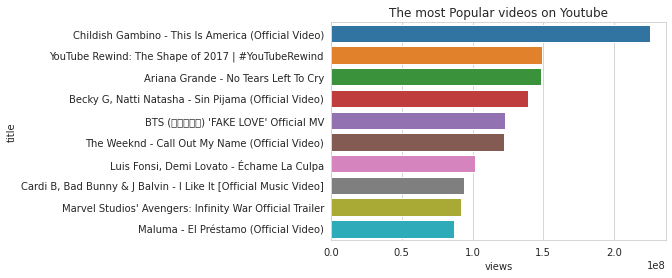

In [ ]:
target = df.copy()
target.sort_values('views', ascending = False, inplace=True)
gg = target[["title", "views"]].head(10)
sns.barplot(x = gg.views, y = gg.title, data = gg).set_title("The most Popular videos on Youtube")

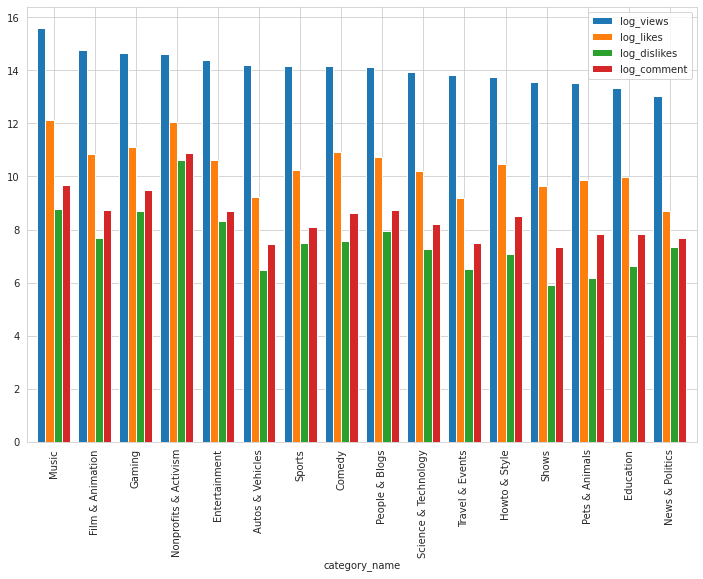

In [ ]:
#Group by category, aggregate by [views, likes, dislikes, comment_count], take the log of these numer to see the variation.
category_all = df.groupby("category_name").agg({"views":"mean", "likes":'mean', 'dislikes':'mean',"comment_count":'mean'})
category_all.sort_values("views", ascending=False, inplace=True)
category_all['log_views']= np.log(category_all.views)
category_all['log_likes']= np.log(category_all.likes)
category_all['log_dislikes']= np.log(category_all.dislikes)
category_all['log_comment']= np.log(category_all['comment_count'])
category_all.drop(columns=["views", "likes","dislikes","comment_count"], axis= 1,inplace=True)
category_all.plot.bar(figsize=(12,8),width=0.8)



In [ ]:
category_all

,log_views,log_likes,log_dislikes,log_comment
category_name,,,,
Music,15.611873,12.144554,8.790637,9.684167
Film & Animation,14.749793,10.861377,7.670398,8.717836
Gaming,14.659268,11.125458,8.710765,9.507721
Nonprofits & Activism,14.612522,12.047171,10.602443,10.875932
Entertainment,14.372196,10.635885,8.331359,8.717157
Autos & Vehicles,14.186720,9.238539,6.482310,7.460077
Sports,14.169001,10.240925,7.481832,8.107226
Comedy,14.167931,10.916447,7.581887,8.610672
People & Blogs,14.114733,10.746454,7.931181,8.727064


In [ ]:
#Publish time (views)
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['year'] = df['publish_time'].dt.year
df['month'] = df['publish_time'].dt.month
df['day'] = df['publish_time'].dt.day_name()
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,num_days_trending,year,month,day
0,9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,17,2017-11-13 02:05:26+00:00,NFL Football offense defense afc nfc ...,81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,0,0,0,New England Patriots returner Dion Lewis blast...,Sports,1,2017,11,Monday
1,Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,1,2017-11-12 18:00:03+00:00,screenjunkies screen junkies sj news hone...,288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,0,0,0,With Justice League approaching fast we rewatc...,Film & Animation,1,2017,11,Sunday
2,goP4Z5wyOlM,2017-11-14,Iraq-Iran earthquake: Deadly tremor hits borde...,BBC News,25,2017-11-12 21:16:40+00:00,bbc bbc news news iran iran news iraq...,34785,308,26,413,https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg,0,0,0,A strong 7.2-magnitude earthquake has rattled ...,News & Politics,1,2017,11,Sunday
3,8NHA23f7LvU,2017-11-14,Jason Momoa Wows Hugh Grant With Some Dothraki...,The Graham Norton Show,24,2017-11-10 19:06:23+00:00,Graham Norton Graham Norton Show Official E...,1496225,16116,236,605,https://i.ytimg.com/vi/8NHA23f7LvU/default.jpg,0,0,0,I think Sarah Millican was very excited for th...,Entertainment,1,2017,11,Friday
4,IE-xepGLVt8,2017-11-14,Mayo Clinic's first face transplant patient me...,Mayo Clinic,28,2017-11-10 12:04:17+00:00,Mayo Clinic Health Care (Issue) Healthcare ...,237307,1896,74,260,https://i.ytimg.com/vi/IE-xepGLVt8/default.jpg,0,0,0,One and a half years after the surgery that tr...,Science & Technology,1,2017,11,Friday


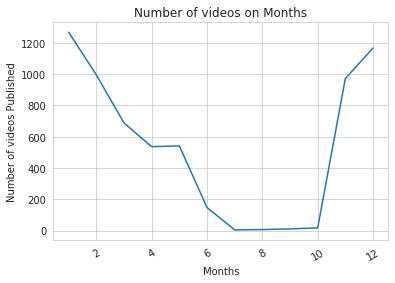

In [ ]:
#videos on each month 
num_month = df.month.value_counts()
months = list(range(1,13))
plt.xlabel("Months")
plt.ylabel("Number of videos Published")
plt.title("Number of videos on Months")
plt.xticks(rotation=30)
sns.lineplot(x=num_month.index.astype('int'), y = num_month)

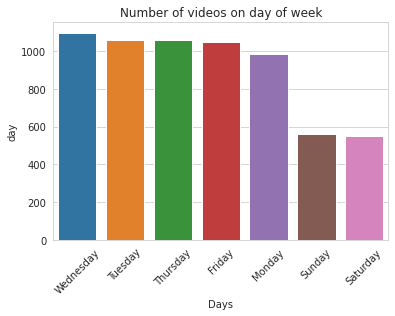

In [ ]:
num = df.day.value_counts()
plt.xlabel("Days")
plt.ylabel("Number of videos Published")
plt.title("Number of videos on day of week")
plt.xticks(rotation=45)
sns.barplot(num.index,num)

In [ ]:
engagment_rate = (df.likes + df.dislikes + df['comment_count']) / df.views

In [ ]:
df['engagment_rate'] = engagment_rate

In [ ]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,num_days_trending,year,month,day,engagment_rate
0,9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,17,2017-11-13 02:05:26+00:00,NFL Football offense defense afc nfc ...,81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,0,0,0,New England Patriots returner Dion Lewis blast...,Sports,1,2017,11,Monday,0.010531
1,Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,1,2017-11-12 18:00:03+00:00,screenjunkies screen junkies sj news hone...,288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,0,0,0,With Justice League approaching fast we rewatc...,Film & Animation,1,2017,11,Sunday,0.036058
2,goP4Z5wyOlM,2017-11-14,Iraq-Iran earthquake: Deadly tremor hits borde...,BBC News,25,2017-11-12 21:16:40+00:00,bbc bbc news news iran iran news iraq...,34785,308,26,413,https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg,0,0,0,A strong 7.2-magnitude earthquake has rattled ...,News & Politics,1,2017,11,Sunday,0.021475
3,8NHA23f7LvU,2017-11-14,Jason Momoa Wows Hugh Grant With Some Dothraki...,The Graham Norton Show,24,2017-11-10 19:06:23+00:00,Graham Norton Graham Norton Show Official E...,1496225,16116,236,605,https://i.ytimg.com/vi/8NHA23f7LvU/default.jpg,0,0,0,I think Sarah Millican was very excited for th...,Entertainment,1,2017,11,Friday,0.011333
4,IE-xepGLVt8,2017-11-14,Mayo Clinic's first face transplant patient me...,Mayo Clinic,28,2017-11-10 12:04:17+00:00,Mayo Clinic Health Care (Issue) Healthcare ...,237307,1896,74,260,https://i.ytimg.com/vi/IE-xepGLVt8/default.jpg,0,0,0,One and a half years after the surgery that tr...,Science & Technology,1,2017,11,Friday,0.009397


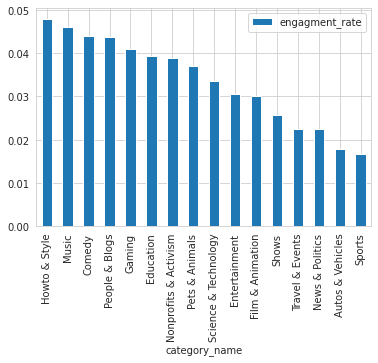

In [ ]:
engagment = df.groupby("category_name").agg({"engagment_rate":'mean'})
engagment.sort_values("engagment_rate", ascending=False, inplace=True)
engagment.plot.bar()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

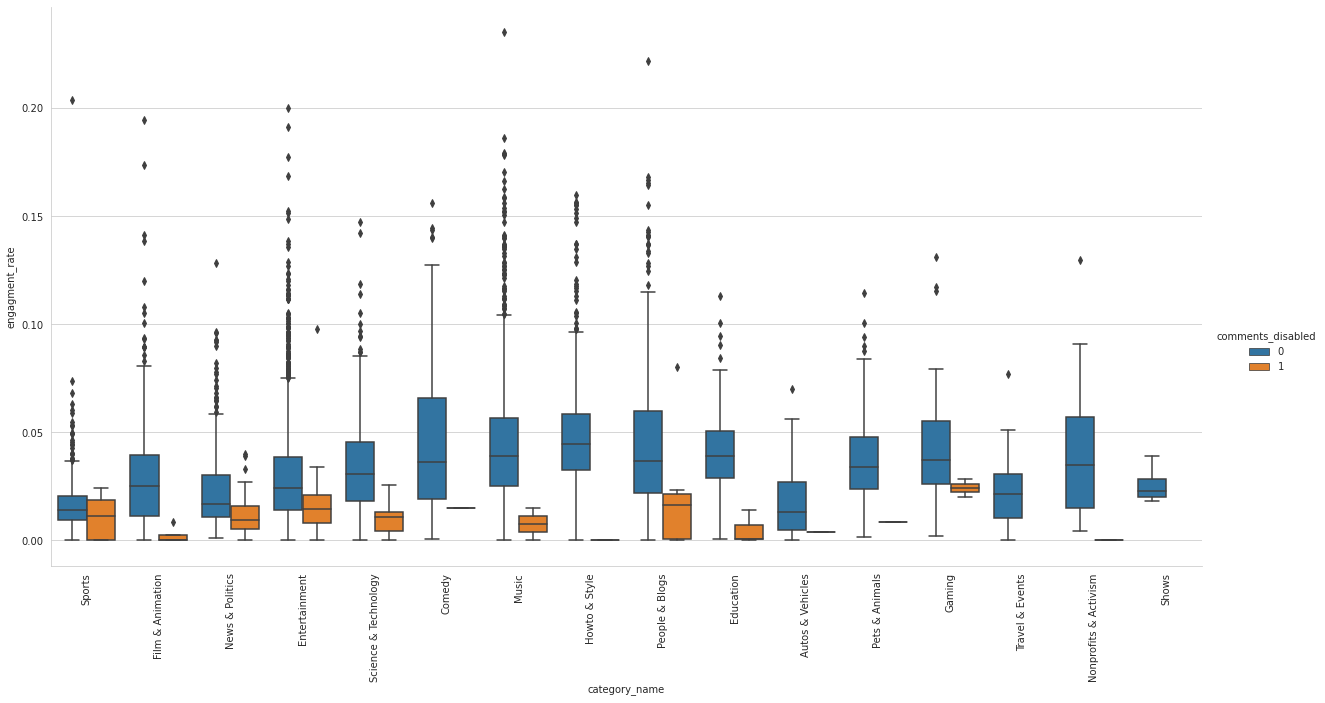

In [ ]:
sns.catplot(data=df, x = 'category_name', y = 'engagment_rate', height= 8.5, aspect = 2, kind = 'box', hue = 'comments_disabled')
plt.xticks(rotation=90)

## a) Additional EDA

In [ ]:
# use spacy cli
MODEL = "en_core_web_lg"

# https://spacy.io/models/en
cli.download(MODEL)

# nlp = language model
nlp = spacy.load(MODEL)


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
df.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,num_days_trending,year,month,day,engagment_rate
0,9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,17,2017-11-13 02:05:26+00:00,NFL Football offense defense afc nfc ...,81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,0,0,0,New England Patriots returner Dion Lewis blast...,Sports,1,2017,11,Monday,0.010531
1,Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,1,2017-11-12 18:00:03+00:00,screenjunkies screen junkies sj news hone...,288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,0,0,0,With Justice League approaching fast we rewatc...,Film & Animation,1,2017,11,Sunday,0.036058
2,goP4Z5wyOlM,2017-11-14,Iraq-Iran earthquake: Deadly tremor hits borde...,BBC News,25,2017-11-12 21:16:40+00:00,bbc bbc news news iran iran news iraq...,34785,308,26,413,https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg,0,0,0,A strong 7.2-magnitude earthquake has rattled ...,News & Politics,1,2017,11,Sunday,0.021475


In [ ]:
ents = []

In [ ]:
for i in df['tags'].tolist():
    doc = nlp(i)
    for entity in doc.ents:
        ents.append((entity.text,entity.label_))

In [ ]:
type(ents)

list

In [ ]:
len(ents)

32516

In [ ]:
ents

[('NFL', 'ORG'),
 ('afc   nfc   ', 'ORG'),
 ('American Football', 'ORG'),
 ('9   wk 9   ', 'DATE'),
 ('broncos   lewis   ', 'PRODUCT'),
 ('st=football', 'ORG'),
 ('li=nfl', 'ORG'),
 ('jared leto', 'PERSON'),
 ('superman   bvs   dceu   dc', 'ORG'),
 ('joker harley quinn   margot', 'PERSON'),
 ('robbie   suicide squad', 'ORG'),
 ('bbc', 'ORG'),
 ('bbc news   news', 'ORG'),
 ('iran', 'GPE'),
 ('iraq', 'GPE'),
 ('iraq', 'GPE'),
 ('Iraq', 'GPE'),
 ('Graham Norton', 'PERSON'),
 ('Graham Norton', 'PERSON'),
 ('Graham Norton', 'PERSON'),
 ('graham Norton', 'PERSON'),
 ('graham Norton', 'PERSON'),
 ('graham Norton', 'PERSON'),
 ('sarah millican   kelly clarkson   graham norton red', 'PERSON'),
 ('Mayo Clinic', 'ORG'),
 ('Healthcare Science (Field Of Study', 'ORG'),
 ('Dalal Obaid Center', 'PERSON'),
 ('James Corden', 'PERSON'),
 ('The Late Late Show   Colbert   ', 'WORK_OF_ART'),
 ('late night', 'TIME'),
 ('late night', 'TIME'),
 ('Stephen Colbert   Comedy', 'PERSON'),
 ('CBS', 'ORG'),
 ('Late 

In [ ]:
ent_df = pd.DataFrame(ents,columns = ['text','entity'])

In [ ]:
ent_df.head(3)

,text,entity
0,NFL,ORG
1,afc nfc,ORG
2,American Football,ORG


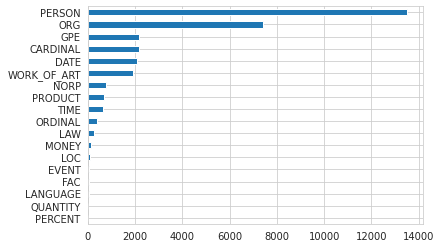

In [ ]:
counts = ent_df.entity.value_counts()
counts.sort_values().plot(kind = 'barh')

In [ ]:
ent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32516 entries, 0 to 32515
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    32516 non-null  object
 1   entity  32516 non-null  object
dtypes: object(2)
memory usage: 508.2+ KB


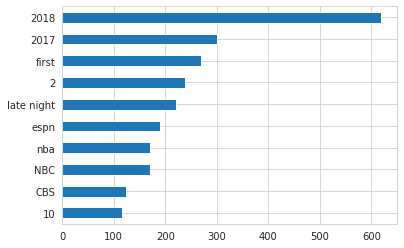

In [ ]:
top_text = ent_df['text'].value_counts().head(10)
top_text.sort_values().plot(kind = 'barh')

## b) Sentiment analysis

In [ ]:
# setup the afinn "model"
afinn = Afinn()

df.fillna('',inplace=True)
afinn_score_list=[]
i=0
while (i < len(df)):
  if (df['description'][i]==''): afinn_score_list.append(0)
  else:
    print(i,afinn.score(df['description'][i]))
    test = afinn.score(df['description'][i])
    afinn_score_list.append(test)
  i=i+1
afinn_score_list

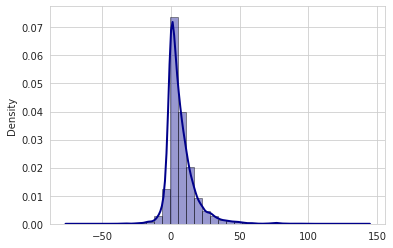

In [ ]:
sns.distplot(afinn_score_list, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

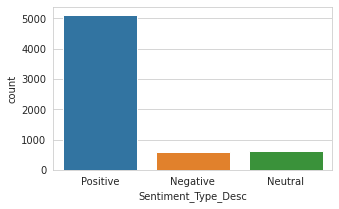

In [ ]:
from textblob import TextBlob
bloblist_desc = list()

df_description=df['description'].astype(str)
for row in df_description:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['sentence','sentiment','polarity'])
 
def f(df_polarity_desc):
    if df_polarity_desc['sentiment'] > 0:
        sentiment = "Positive"
    elif df_polarity_desc['sentiment'] == 0:
        sentiment = "Neutral"
    else:
        sentiment = "Negative"
    return sentiment

df_polarity_desc['Sentiment_Type_Desc'] = df_polarity_desc.apply(f, axis=1)

plt.figure(figsize=(5,3))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type_Desc", data=df_polarity_desc)

## c) Preliminary Clustering

In [ ]:
#We subset only numeric variables in our dataset for our preliminary clustering.
df_cluster = df[['video_id','views','likes','dislikes','comment_count','comments_disabled', 'ratings_disabled','video_error_or_removed','num_days_trending']]

In [ ]:
df_cluster.set_index('video_id', inplace = True)

In [ ]:
df_cluster.dropna(inplace = True)

In [ ]:
df_cluster_num = df_cluster.copy()

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster_num)

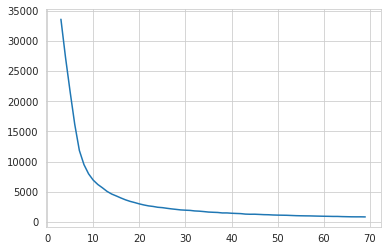

In [ ]:
KRANGE = range(3,70)
ss = []

for k in KRANGE:
    km = KMeans(k)
    lab = km.fit_predict(df_scaled)
    ss.append(km.inertia_)


sns.lineplot(KRANGE, ss)
plt.show()

Text(0.5, 1.0, 'K15 Silhouette Analysis')

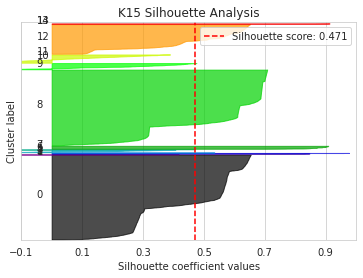

In [ ]:
k15=KMeans(15)

k15_labs = k15.fit_predict(df_scaled)
skplt.metrics.plot_silhouette(df_scaled, k15_labs)
plt.title('K15 Silhouette Analysis')

# F. Unsupersived Machine Learning

In [ ]:
youtube = df.dropna()

In [ ]:
youtube.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,num_days_trending,year,month,day,engagment_rate
0,9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,17,2017-11-13 02:05:26+00:00,NFL Football offense defense afc nfc ...,81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,0,0,0,New England Patriots returner Dion Lewis blast...,Sports,1,2017,11,Monday,0.010531
1,Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,1,2017-11-12 18:00:03+00:00,screenjunkies screen junkies sj news hone...,288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,0,0,0,With Justice League approaching fast we rewatc...,Film & Animation,1,2017,11,Sunday,0.036058
2,goP4Z5wyOlM,2017-11-14,Iraq-Iran earthquake: Deadly tremor hits borde...,BBC News,25,2017-11-12 21:16:40+00:00,bbc bbc news news iran iran news iraq...,34785,308,26,413,https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg,0,0,0,A strong 7.2-magnitude earthquake has rattled ...,News & Politics,1,2017,11,Sunday,0.021475
3,8NHA23f7LvU,2017-11-14,Jason Momoa Wows Hugh Grant With Some Dothraki...,The Graham Norton Show,24,2017-11-10 19:06:23+00:00,Graham Norton Graham Norton Show Official E...,1496225,16116,236,605,https://i.ytimg.com/vi/8NHA23f7LvU/default.jpg,0,0,0,I think Sarah Millican was very excited for th...,Entertainment,1,2017,11,Friday,0.011333
4,IE-xepGLVt8,2017-11-14,Mayo Clinic's first face transplant patient me...,Mayo Clinic,28,2017-11-10 12:04:17+00:00,Mayo Clinic Health Care (Issue) Healthcare ...,237307,1896,74,260,https://i.ytimg.com/vi/IE-xepGLVt8/default.jpg,0,0,0,One and a half years after the surgery that tr...,Science & Technology,1,2017,11,Friday,0.009397


In [ ]:
youtube.shape

(6351, 22)

In [ ]:
#Combine the text we need
text_info = youtube.tags + youtube.description

In [ ]:
text_info

0       NFL  Football   offense   defense   afc   nfc ...
1       screenjunkies  screen junkies   sj news   hone...
2       bbc  bbc news   news   iran   iran news   iraq...
3       Graham Norton  Graham Norton Show Official   E...
4       Mayo Clinic  Health Care (Issue)   Healthcare ...
                              ...                        
6346    aarons animals  aarons   animals   cat   cats ...
6347                                               [none]
6348    I gave safiya nygaard a perfect hair makeover ...
6349    Black Panther  HISHE   Marvel   Infinity War  ...
6350    call of duty  cod   activision   Black Ops 4 C...
Length: 6351, dtype: object

In [ ]:
#Check the size of the text
text_info.shape

(6351,)

In [ ]:
#Utilize tfid vectorizer to tokenlize our text
tf = TfidfVectorizer()
tf.fit(text_info)

TfidfVectorizer()

In [ ]:
#Check the vocabulary
tf.vocabulary_

{'nfl': 29963,
 'football': 16522,
 'offense': 30758,
 'defense': 11740,
 'afc': 2189,
 'nfc': 29961,
 'american': 2866,
 'highlight': 19908,
 'highlights': 19914,
 'game': 17291,
 'games': 17306,
 'sport': 40213,
 'sports': 40216,
 'action': 1923,
 'play': 32967,
 'plays': 32992,
 'season': 37852,
 '2017': 631,
 'rookie': 36512,
 'rookies': 36513,
 'recap': 35123,
 'run': 36810,
 'sprint': 40261,
 'catch': 8013,
 'huge': 20557,
 'amazing': 2820,
 'touchdown': 43464,
 'td': 42140,
 'week': 46106,
 'wk': 46708,
 'new': 29905,
 'england': 14477,
 'patriots': 32043,
 'pats': 32049,
 'denver': 11977,
 'broncos': 6812,
 'lewis': 25132,
 'kickoff': 23605,
 'kick': 23599,
 'return': 35884,
 'special': 39993,
 'teams': 42182,
 'sp': 39909,
 'dt': 13419,
 '11': 145,
 '12t20': 242,
 '30': 861,
 '00': 0,
 '05': 51,
 'vl': 45512,
 'en': 14370,
 'us': 44795,
 'st': 40342,
 'li': 25163,
 'ti': 42954,
 'home': 20220,
 'den': 11937,
 'away': 4266,
 'ne': 29687,
 'scp': 37725,
 'athlete_in_match': 3952

In [ ]:
#Check the len of vocabulary
len(tf.vocabulary_)

49667

In [ ]:
dtm = tf.transform(text_info)

In [ ]:
dtm.shape

(6351, 49667)

In [ ]:
type(dtm)

scipy.sparse.csr.csr_matrix

In [ ]:
feature_names = tf.get_feature_names()

In [ ]:
feature_names

['00',
 '000',
 '0000',
 '0001',
 '000fps',
 '000hp',
 '000lbs',
 '000mah',
 '000nm',
 '001',
 '002',
 '005',
 '007',
 '00am',
 '00beauty',
 '00benefit',
 '00brows',
 '00clarisonic',
 '00cover',
 '00eyes',
 '00face',
 '00it',
 '00kkw',
 '00l',
 '00mac',
 '00pm',
 '00tarte',
 '00urban',
 '00wet',
 '00wunder2',
 '00z',
 '01',
 '01am',
 '01producer',
 '01t18',
 '01t20',
 '02',
 '0211have',
 '023',
 '02t18',
 '02t20',
 '03',
 '032',
 '0330hrs',
 '03909',
 '03pm',
 '03t20',
 '04',
 '04royalty',
 '04t18',
 '04t20',
 '05',
 '0544952560',
 '0551',
 '05kevyn',
 '05t20',
 '06',
 '06t16',
 '07',
 '075',
 '076401',
 '07t16',
 '08',
 '0800',
 '08282016ntflxukie',
 '08282016ntflxuscan',
 '08807',
 '08807follow',
 '08pm',
 '09',
 '09t20',
 '0e6',
 '0e7',
 '0g',
 '0iphone',
 '0l',
 '0x87a3f850c2bf20d929303200f53aab8d8d7e2279',
 '0x8b3a734e3af08b35020e449a0f9de69d5f978700',
 '0x92bc19cf513bdc8e8576cc0d3c96a6870489e6fb',
 '0xd765bf71f5c10f91d704d792de4b21712b132f23',
 '10',
 '100',
 '1000',
 '10000',
 '

In [ ]:
first_doc_vector = dtm[0]

In [ ]:
first_doc_vector

<1x49667 sparse matrix of type '<class 'numpy.float64'>'
	with 130 stored elements in Compressed Sparse Row format>

In [ ]:
dt = pd.DataFrame(first_doc_vector.T.todense(), index=feature_names, columns=["tfidf"]) 

In [ ]:
dt

,tfidf
00,0.090496
000,0.000000
0000,0.000000
0001,0.000000
000fps,0.000000
...,...
흐물한,0.000000
흘린,0.000000
희희,0.000000
힐링쿠킹이에요,0.000000


In [ ]:
#Utilize uMAP for Dimension reduction 
umap = UMAP(random_state=820)
embeds = umap.fit_transform(dtm)

In [ ]:
embeds.shape

(6351, 2)

In [ ]:
type(embeds)

numpy.ndarray

## a) Spacy

In [ ]:
model = "en_core_web_lg" #md
cli.download(model)
nlp = spacy.load(model)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [ ]:
#process the text
EXCL = ['tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
docs = list(nlp.pipe(text_info, disable=EXCL))

In [ ]:
#Get the vectors
dv = [doc.vector for doc in docs]
dv = np.array(dv)
dv.shape

(6351, 300)

In [ ]:
goal = pd.DataFrame(dv, index=youtube.index, columns=range(0,300))

In [ ]:
youtube.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,num_days_trending,year,month,day,engagment_rate
0,9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,17,2017-11-13 02:05:26+00:00,NFL Football offense defense afc nfc ...,81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,0,0,0,New England Patriots returner Dion Lewis blast...,Sports,1,2017,11,Monday,0.010531
1,Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,1,2017-11-12 18:00:03+00:00,screenjunkies screen junkies sj news hone...,288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,0,0,0,With Justice League approaching fast we rewatc...,Film & Animation,1,2017,11,Sunday,0.036058
2,goP4Z5wyOlM,2017-11-14,Iraq-Iran earthquake: Deadly tremor hits borde...,BBC News,25,2017-11-12 21:16:40+00:00,bbc bbc news news iran iran news iraq...,34785,308,26,413,https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg,0,0,0,A strong 7.2-magnitude earthquake has rattled ...,News & Politics,1,2017,11,Sunday,0.021475
3,8NHA23f7LvU,2017-11-14,Jason Momoa Wows Hugh Grant With Some Dothraki...,The Graham Norton Show,24,2017-11-10 19:06:23+00:00,Graham Norton Graham Norton Show Official E...,1496225,16116,236,605,https://i.ytimg.com/vi/8NHA23f7LvU/default.jpg,0,0,0,I think Sarah Millican was very excited for th...,Entertainment,1,2017,11,Friday,0.011333
4,IE-xepGLVt8,2017-11-14,Mayo Clinic's first face transplant patient me...,Mayo Clinic,28,2017-11-10 12:04:17+00:00,Mayo Clinic Health Care (Issue) Healthcare ...,237307,1896,74,260,https://i.ytimg.com/vi/IE-xepGLVt8/default.jpg,0,0,0,One and a half years after the surgery that tr...,Science & Technology,1,2017,11,Friday,0.009397


In [ ]:
numeric = ['views', 'likes', 'dislikes', 'comment_count', 'comments_disabled', 'ratings_disabled','video_error_or_removed','num_days_trending']

In [ ]:
goal[numeric] = youtube[numeric]

In [ ]:
goal.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,num_days_trending
0,-0.024684,0.134497,-0.078833,-0.026666,0.123636,-0.079174,0.083560,0.045293,0.133617,1.154090,-0.271096,0.000744,0.071042,-0.045033,0.004278,0.021560,-0.044147,0.748465,-0.006209,-0.052351,-0.014800,0.033999,0.098070,-0.141645,-0.067312,0.130897,-0.117823,0.032466,0.036945,0.054838,-0.021151,-0.056334,0.011316,0.048036,-0.000297,0.001374,-0.031201,0.034252,-0.023272,0.013665,...,0.113890,0.039139,-0.130462,0.152459,0.075530,-0.014526,-0.020735,0.018472,0.009781,0.057008,-0.077512,0.043524,-0.080011,-0.040941,-0.164506,0.034149,0.015960,-0.021159,0.040736,-0.064503,0.103230,0.024480,0.014710,-0.051267,-0.141364,-0.009315,0.053270,-0.032186,-0.045036,-0.057575,-0.028119,0.028004,81377,655,25,177,0,0,0,1
1,-0.052629,0.100013,-0.040974,-0.006408,0.035894,-0.036135,0.072086,-0.014370,0.071059,1.291619,-0.146766,-0.090604,0.087796,-0.003984,-0.096218,-0.030231,-0.003466,0.521071,-0.093944,0.015870,0.030520,-0.062312,0.047860,-0.070632,-0.008257,0.067803,-0.054130,-0.004179,0.027439,0.038803,-0.006373,0.047767,-0.092822,0.105669,-0.024642,0.013182,-0.026221,0.021896,-0.135735,0.002165,...,0.124556,0.060024,-0.095510,-0.001146,-0.018739,-0.016570,-0.050575,0.051827,0.010378,0.004609,0.016126,0.111946,0.028201,0.017620,-0.065667,0.022346,0.017303,-0.005609,0.036423,-0.068910,0.026276,-0.086108,-0.120001,-0.071129,-0.029510,-0.017558,0.091722,-0.062387,-0.026636,-0.102898,-0.025729,0.070270,288922,7515,792,2111,0,0,0,1
2,-0.127648,0.197813,0.035939,0.029176,0.095353,-0.052641,-0.127384,-0.001460,0.004479,1.715067,-0.229751,-0.012800,0.055692,-0.139474,-0.212731,-0.054040,-0.076534,0.792101,-0.157100,-0.076515,0.062344,-0.005130,0.067986,0.005958,0.093878,-0.036952,-0.149992,0.088704,0.027808,0.070069,0.027150,0.008896,-0.069165,0.045446,0.078155,-0.006601,-0.019021,0.054243,-0.069978,0.075046,...,0.103643,0.043244,-0.115071,0.055840,-0.089405,-0.058461,-0.075824,0.056214,0.070576,-0.001892,-0.018135,0.060425,0.141487,-0.025235,-0.110031,0.018851,0.000164,-0.022501,0.063811,-0.088265,0.097648,0.119962,-0.194134,0.052221,-0.049484,-0.079683,0.014177,-0.099951,-0.113906,-0.047577,-0.159194,0.057837,34785,308,26,413,0,0,0,1
3,-0.088658,0.066597,-0.020682,-0.038640,-0.056824,-0.055756,0.074336,-0.102904,0.104340,0.850984,-0.219741,-0.145301,-0.058537,-0.051217,0.010205,-0.040351,-0.048071,0.657177,-0.078089,-0.012468,0.155274,-0.074282,0.079747,-0.064259,-0.028587,0.054141,-0.160865,-0.065844,0.062654,0.024003,0.007340,0.048517,-0.066093,0.187901,-0.002063,-0.028853,-0.215732,0.083642,-0.218865,0.049893,...,0.028184,0.014307,-0.229360,0.080562,0.098578,0.029314,-0.038242,0.090146,0.025791,-0.086897,-0.111829,0.167654,0.055562,0.000655,-0.038157,0.005026,0.049359,0.059616,0.062019,0.023151,-0.086814,-0.054451,0.064286,0.030793,0.083996,-0.039481,0.138909,-0.123102,-0.008517,-0.151373,-0.156796,-0.066401,1496225,16116,236,605,0,0,0,1
4,-0.033776,0.126825,-0.040346,0.045268,-0.011338,-0.218884,-0.002893,-0.070284,0.163734,1.775128,-0.135175,0.120209,0.033575,-0.067882,-0.074134,0.037723,0.015021,0.907307,-0.100065,-0.005991,-0.041206,0.025584,-0.278396,0.036748,0.054270,0.001051,0.037354,0.085963,0.114744,0.043936,-0.037821,0.027848,0.117614,-0.035301,0.165247,0.031830,-0.028518,-0.027339,-0.007345,0.066957,...,0.041270,-0.034846,0.041365,-0.117445,-0.139847,0.061704,0.000245,0.091537,-0.020565,0.024950,-0.089819,0.119486,0.058440,0.063664,-0.018553,-0.038755,-0.020330,-0.112840,-0.075661,-0.057825,0.016884,0.050543,0.066387,-0.036715,0.021634,-0.098292,-0.064241,-0.055684,-0.018356,0.085949,-0.003542,0.068568,237307,1896,74,260,0,0,0,1


In [ ]:
#Utilize uMAP for Dimension reduction 
umap = UMAP(random_state=820)
embeds = umap.fit_transform(goal)

In [ ]:
embeds.shape

(6351, 2)

## b) H-clustering

In [ ]:
# standardized 
scaler = StandardScaler()
fscaled = scaler.fit_transform(embeds)
type(fscaled)

numpy.ndarray

In [ ]:
fdist = pdist(embeds)
fdist

array([12.09518244,  4.77077211, 15.96729915, ..., 16.82643253,
       16.90796916,  5.71751684])

In [ ]:
# by default it's single linkage(shortest one)
METHOD = ["single", "complete", "average", "ward"]
plt.figure(figsize=(15,5))
plt.show()

<Figure size 1080x360 with 0 Axes>

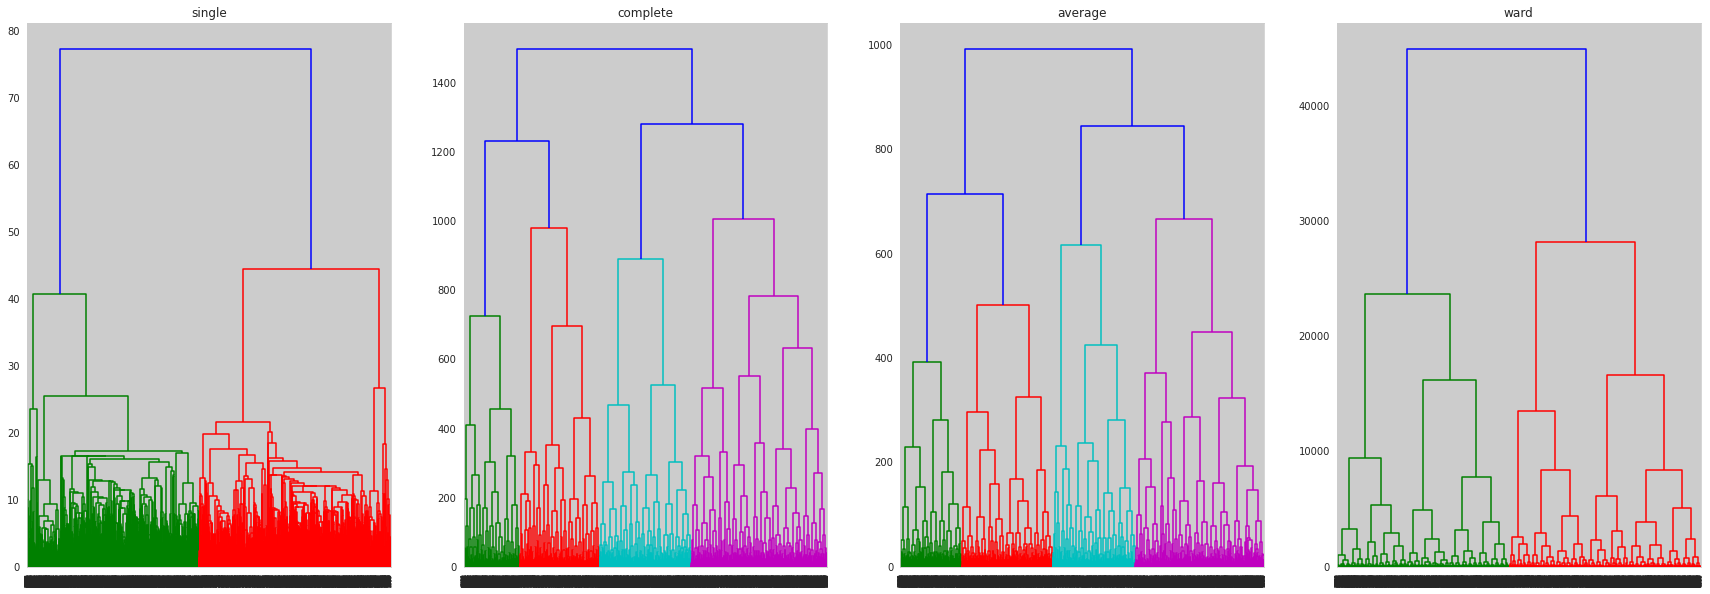

In [ ]:
#loop and build plot
for i, m in enumerate(METHOD):
  plt.subplot(1,4, i+1)
  plt.title(m)
  dendrogram(linkage(squareform(fdist), method = m), leaf_rotation = 90)
plt.gcf().set_size_inches(30, 10)
plt.show()

In [ ]:
hc1=linkage(squareform(fdist), method="ward")
hc1

array([[3.68400000e+03, 5.17300000e+03, 2.44971965e-03, 2.00000000e+00],
       [2.45300000e+03, 2.97600000e+03, 4.37559716e-03, 2.00000000e+00],
       [2.64300000e+03, 3.05900000e+03, 5.27084725e-03, 2.00000000e+00],
       ...,
       [1.26940000e+04, 1.26960000e+04, 2.36805312e+04, 3.01000000e+03],
       [1.26950000e+04, 1.26970000e+04, 2.81408872e+04, 3.34100000e+03],
       [1.26980000e+04, 1.26990000e+04, 4.48922234e+04, 6.35100000e+03]])

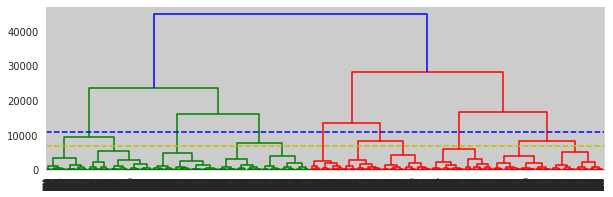

In [ ]:
dendrogram(hc1)
plt.axhline(y = 7000, color = 'y', linestyle = "--")
plt.axhline(y = 11000, color = 'b', linestyle = "--")
plt.gcf().set_size_inches(6, 3)
plt.show()

## c) K-means


In [ ]:

# Kmeans
KS = range(2, 15)

# storage
inertia = []
silo = []
X = embeds

for k in KS:
  km = KMeans(k)
  km.fit(X)
  labs = km.predict(X)
  inertia.append(km.inertia_)
  silo.append(silhouette_score(X, labs))

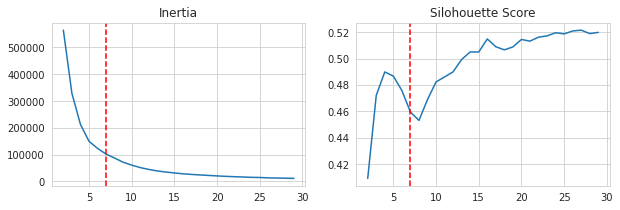

In [ ]:
plt.figure(figsize=(10,3))


plt.subplot(1, 2, 1)
plt.title("Inertia")
sns.lineplot(KS, inertia)
plt.axvline(x=7, color='r',linestyle='--')

plt.subplot(1, 2, 2)
plt.title("Silohouette Score")
sns.lineplot(KS, silo)
plt.axvline(x=7, color='r',linestyle='--')
plt.show()

In [ ]:
for i, s in enumerate(silo[:10]):
  print(i+2,s) # +2 to align num clusters with value

2 0.40944755
3 0.47220793
4 0.48986912
5 0.48671514
6 0.4758289
7 0.45960313
8 0.45321894
9 0.46899238
10 0.4823283
11 0.4860825


In [ ]:
# get the model
k7 = KMeans(7)
k7_labs = k7.fit_predict(X)

# metrics
k7_silo = silhouette_score(X, k7_labs)
k7_ssamps = silhouette_samples(X, k7_labs)
np.unique(k7_labs)

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

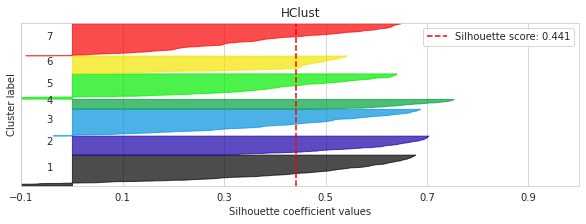

In [ ]:
c1 = fcluster(hc1, 7, criterion="maxclust")
# lets compare via silo
skplt.metrics.plot_silhouette(X, c1, title="HClust", figsize=(10,3))
plt.show()

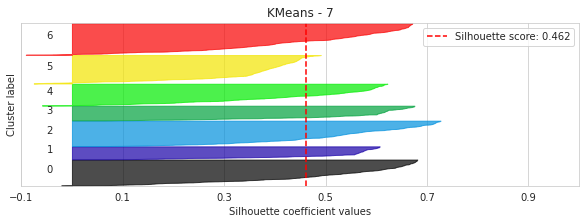

In [ ]:
skplt.metrics.plot_silhouette(X, k7_labs, title="KMeans - 7", figsize=(10,3))
plt.show()

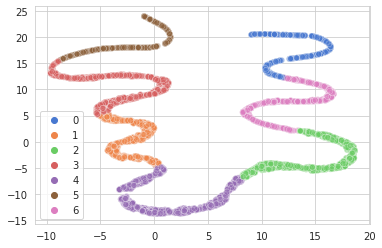

In [ ]:
km = KMeans(7)
km.fit(embeds)

preds = km.predict(embeds)
sns.scatterplot(x=embeds[:, 0], y=embeds[:, 1], hue=preds, alpha=.5, palette="muted")

## d) Word Cloud

In [ ]:
youtube['clusters'] = k7_labs

In [ ]:
youtube.to_csv('youtube_clustered.csv')

In [ ]:
def wordcloud(text):
    wc = WordCloud(background_color="white")
    st = ''
    for i in text:
        st+= i
    wordcloud = wc.generate(st)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

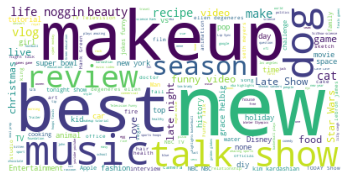

In [ ]:
#Cluster - 0 Wordcloud
wordcloud(youtube[youtube['clusters']==0].tags)

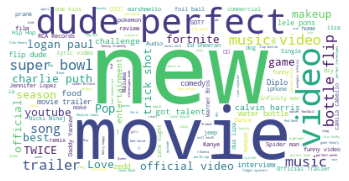

In [ ]:
wordcloud(youtube[youtube['clusters']==1].tags)

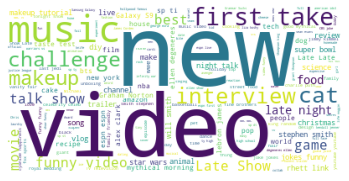

In [ ]:
wordcloud(youtube[youtube['clusters']==2].tags)

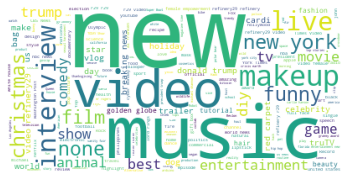

In [ ]:
wordcloud(youtube[youtube['clusters']==3].tags)

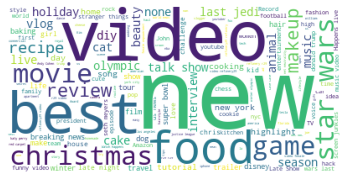

In [ ]:
wordcloud(youtube[youtube['clusters']==4].tags)

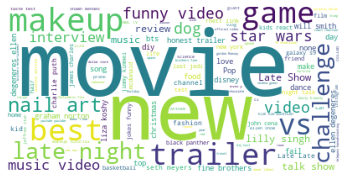

In [ ]:
wordcloud(youtube[youtube['clusters']==5].tags)

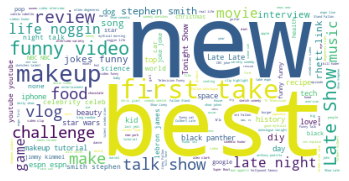

In [ ]:
wordcloud(youtube[youtube['clusters']==6].tags)

In [ ]:
## Creating Wordclouds using BERT

In [ ]:
pip install keybert

In [ ]:
from keybert import KeyBERT

In [ ]:
kw_model = KeyBERT()

In [ ]:
def wordcloud_keybert(text):
  wc = WordCloud(background_color="white")
  st = ''
  for j in text:
   foo = " ".join(j.split())
   #print(len(foo.split()))
   #print(foo)
   try:
       keywords = kw_model.extract_keywords(foo,keyphrase_ngram_range=(1, 1), stop_words='english', 
                              use_maxsum=True, nr_candidates=20, top_n=5)
       #print(keywords)
       for i in keywords:
         st += (i[0] + ' ')
   except:
       print("")
  wordcloud = wc.generate(st)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

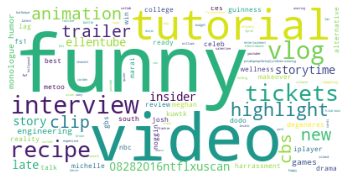

In [ ]:
wordcloud_keybert(youtube[youtube['clusters']==0].tags.sample(200, random_state = 420))

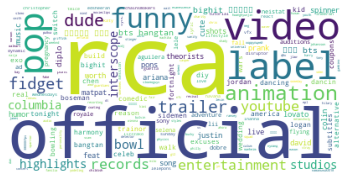

In [ ]:
wordcloud_keybert(youtube[youtube['clusters']==1].tags.sample(200, random_state = 420))

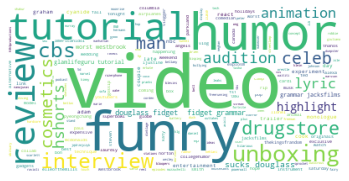

In [ ]:
wordcloud_keybert(youtube[youtube['clusters']==2].tags.sample(200, random_state = 420))

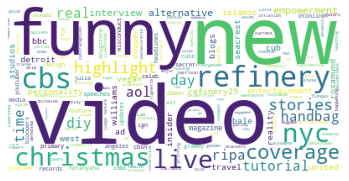

In [ ]:
wordcloud_keybert(youtube[youtube['clusters']==3].tags.sample(200, random_state = 420))

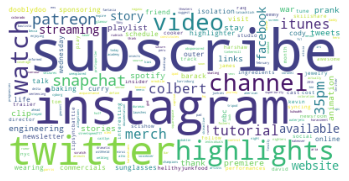

In [ ]:
wordcloud_keybert(youtube[youtube['clusters']==4].description.sample(200, random_state = 420))

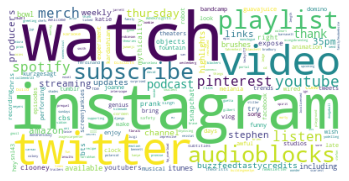

In [ ]:
wordcloud_keybert(youtube[youtube['clusters']==5].description.sample(200, random_state = 420))

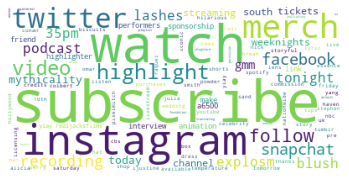

In [ ]:
wordcloud_keybert(youtube[youtube['clusters']==6].description.sample(200, random_state = 420))